<ipython-input-28-5260fe86f60b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_features[['Disease', 'Organism site', 'Sex']] = patient_features[['Disease', 'Organism site', 'Sex']].astype(str)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - AUC: 0.7379 - accuracy: 0.7199 - loss: 2.1645 - val_AUC: 0.9592 - val_accuracy: 0.8036 - val_loss: 0.8569
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8498 - accuracy: 0.8105 - loss: 1.0676 - val_AUC: 0.9779 - val_accuracy: 0.8571 - val_loss: 0.4495
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.9215 - accuracy: 0.8725 - loss: 0.5782 - val_AUC: 0.9796 - val_accuracy: 0.9286 - val_loss: 0.1960
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9304 - accuracy: 0.8876 - loss: 0.3692 - val_AUC: 0.9813 - val_accuracy: 0.9464 - val_loss: 0.1628
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9626 - accuracy: 0.8815 - loss: 0.2427 - val_AUC: 0.9847 - val_accuracy: 0.8750 - val_loss: 0.2867
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9621 - accuracy: 0.9029 - loss: 0.2438 - val_AUC: 0.9847 - val_accuracy: 0.9464 - val_loss: 0.1619
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step -

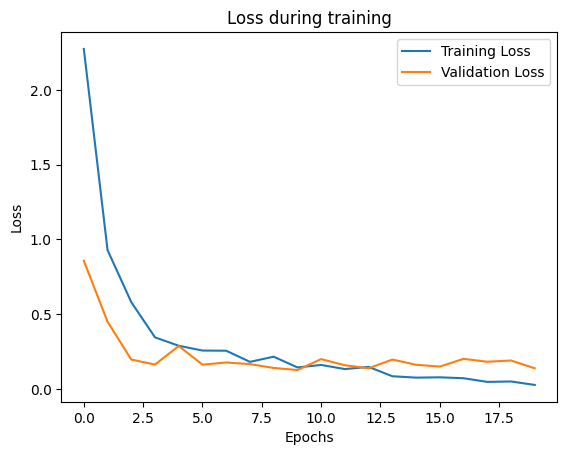

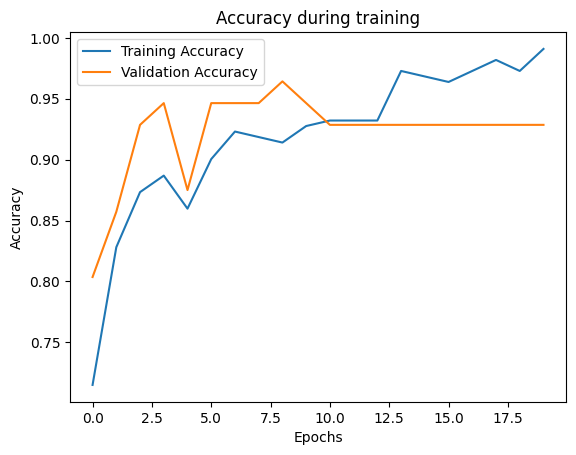

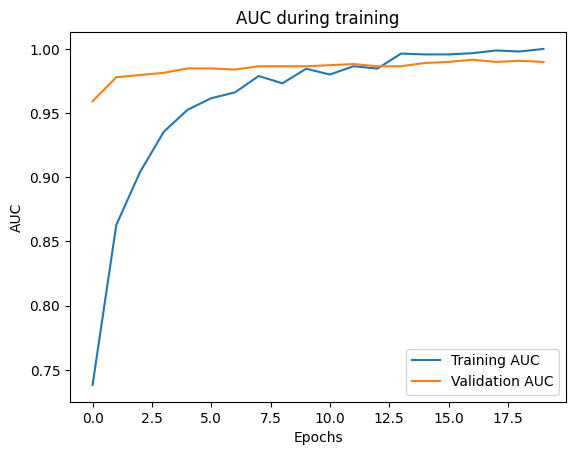

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Load dataset
data = pd.read_csv('/content/Merged_IBD.csv', low_memory=False)

# Step 2: Drop non-numeric genomic columns like 'Unnamed: 16383' and handle missing values
genomic_features = data.drop(columns=['Run', 'Age', 'Disease', 'Organism site', 'Sex'])

# Ensure genomic features are numeric, replace missing values (NaN) with 0
genomic_features = genomic_features.apply(pd.to_numeric, errors='coerce').fillna(0)

# Step 3: Process patient-related features
patient_features = data[['Run', 'Disease', 'Organism site', 'Sex']]

# Convert categorical columns to string to avoid mixed type issues
patient_features[['Disease', 'Organism site', 'Sex']] = patient_features[['Disease', 'Organism site', 'Sex']].astype(str)

# Step 4: Target variable - Combine UC and CD into IBD (1 for IBD, 0 for Control)
data['IBD'] = data['Disease'].apply(lambda x: 1 if x in ['UC', 'CD'] else 0)
y = data['IBD'].values  # Binary target

# Step 5: One-hot encode categorical patient features (Organism site, Sex)
categorical_features = ['Organism site', 'Sex']
onehot = OneHotEncoder()
patient_features_encoded = onehot.fit_transform(patient_features[categorical_features]).toarray()

# Convert to dataframe and remove 'Run' column for scaling
patient_features_encoded_df = pd.DataFrame(patient_features_encoded, columns=onehot.get_feature_names_out(categorical_features))
patient_features_final = patient_features_encoded_df

# Step 6: Normalize/Standardize genomic features
scaler_genomic = StandardScaler()
genomic_scaled = scaler_genomic.fit_transform(genomic_features)

# Normalize/Standardize patient features (only numeric features)
patient_scaled = StandardScaler().fit_transform(patient_features_final)

# Step 7: Split the data into training and test sets
X_train_genomic, X_test_genomic, X_train_patient, X_test_patient, y_train, y_test = train_test_split(
    genomic_scaled, patient_scaled, y, test_size=0.2, random_state=42
)

# Step 8: Create the genomic input model
genomic_input = Input(shape=(X_train_genomic.shape[1],))
genomic_branch = Dense(128, activation='relu')(genomic_input)
genomic_branch = Dropout(0.3)(genomic_branch)
genomic_branch = Dense(64, activation='relu')(genomic_branch)

# Step 9: Create the patient input model
patient_input = Input(shape=(X_train_patient.shape[1],))
patient_branch = Dense(128, activation='relu')(patient_input)
patient_branch = Dropout(0.3)(patient_branch)
patient_branch = Dense(64, activation='relu')(patient_branch)

# Step 10: Merge the branches
merged = Concatenate()([genomic_branch, patient_branch])

# Step 11: Final output layer (binary classification)
output = Dense(1, activation='sigmoid')(merged)  # Binary output using sigmoid

# Step 12: Define and compile the model
model = Model(inputs=[genomic_input, patient_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Step 13: Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 14: Train the model
history = model.fit(
    [X_train_genomic, X_train_patient], y_train,
    validation_data=([X_test_genomic, X_test_patient], y_test),
    epochs=100, batch_size=32, callbacks=[early_stopping]
)

# Step 15: Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate([X_test_genomic, X_test_patient], y_test)
print(f'Test Accuracy: {test_accuracy}, Test AUC: {test_auc}')

# Step 16: Make predictions
y_pred_prob = model.predict([X_test_genomic, X_test_patient])
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Step 17: Plot training history (loss and accuracy)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC during training')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()
